In [135]:
! git pull

remote: Counting objects: 4, done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/jordanmuraskin/CCD-scripts
   d4e8543..0ef8526  master     -> origin/master
Updating d4e8543..0ef8526
Fast-forward
 analysis/CCD_packages.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.stats import zscore
import CCD_packages
from sklearn.decomposition import FactorAnalysis,PCA
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
reload(CCD_packages)
%pylab inline

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



Populating the interactive namespace from numpy and matplotlib


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['linalg']
`%matplotlib` prevents importing * from pylab and numpy



In [2]:
GroupDF,motionInfo=CCD_packages.getCCDSubjectData()
# goodsubj = CCD_packages.getSubjectList(GroupDF=GroupDF,motionThresh=1,)
goodsubj,badsubj = CCD_packages.getSubjectList(GroupDF=GroupDF,motionThresh=1,poor_performer=14)

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'

pheno=pd.read_csv(phenoFile)
pheno=pheno.set_index('participant').fillna(value=0)


phenoNames=['V1_DBDI_22','V1_CCDAIM_42','V1_CCDAIM_43','V1_CCDAIM_44','V1_CCDAIM_45','V1_CCDSIPI_46','V1_CCDSIPI_47','V1_CCDSIPI_48','V1_CCDRSQ_73','V1_CCDRSQ_74','V1_CCDRSQ_75','V1_CCDPANAS_21','V1_CCDPANAS_22','V1_CCDERQ_11','V1_CCDERQ_12']

X=zscore(pheno.loc[goodsubj][phenoNames],axis=0)

n_subj,n_features=X.shape

No DR .txt file found or error for subject : CCD061
No DR .txt file found or error for subject : CCD061


best n_components by FactorAnalysis CV = 2
best n_components by PCA MLE = 2


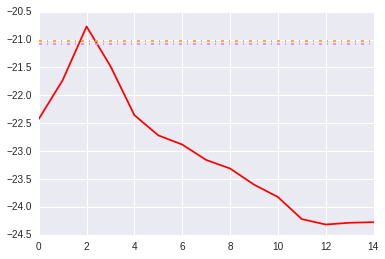

In [3]:
n_components = np.arange(0, n_features, 1)  # options for n_components


def compute_scores(X):
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
#         pca.n_components = n
        fa.n_components = n
#         pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X,cv=10)))

    return fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


fa_scores = compute_scores(X)
n_components_fa = n_components[np.argmax(fa_scores)]

pca = PCA(n_components='mle')
pca.fit(X)
n_components_pca_mle = pca.n_components_
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
print("best n_components by PCA MLE = %d" % n_components_pca_mle)


plt.figure()
plt.plot(n_components, fa_scores, 'r', label='FA scores')

# compare with other covariance estimators
plt.axhline(shrunk_cov_score(X), color='violet',
            label='Shrunk Covariance MLE', linestyle='-.')
plt.axhline(lw_score(X), color='orange',
            label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

# plt.xlabel('nb of components')
# plt.ylabel('CV scores')
# plt.legend(loc='lower right')
# plt.title(title)



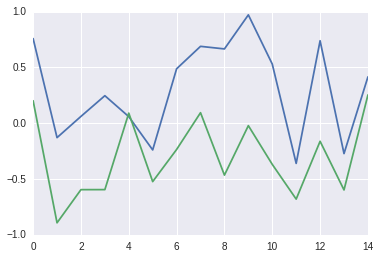

In [4]:
fa = FactorAnalysis(n_components=2)
fa.fit(X)
true_components=fa.components_.T
subjectLoadings=fa.transform(X)

plt.plot(true_components)


#randomization
nperms=10000
rows,columns= X.shape
total_comps=np.zeros((nperms,columns,2))
for n in range(nperms):
    Xshuffle=X.copy()
    for column in range(columns):
        Xshuffle[:,column]=np.random.permutation(Xshuffle[:,column])
    fa = FactorAnalysis(n_components=2)
    fa.fit(Xshuffle)
    components=fa.components_
    total_comps[n,:,:]=components.T

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



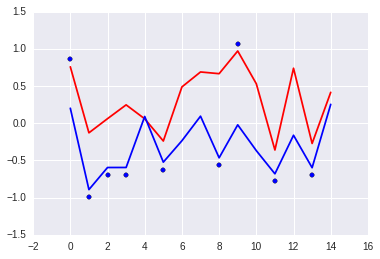

In [5]:
import seaborn as sns
# means=totalcomps.mean(axis=0)
# stds=totalcomps.std(axis=0)
plt.plot(true_components[:,0],'r')
plt.plot(true_components[:,1],'b')

pos=nperms*0.05

first_comp=[]
second_comp=[]

for x in range(14):
    for j in range(2):
        if j:
            limit=np.sort(total_comps[:,x,j])[pos]
        else:
            limit=np.sort(total_comps[:,x,j])[-1*pos]
        
        shift=.1
        if j:
            shift=-.1
        height=true_components[x,j]+shift
        if j:
            if limit>true_components[x,j]:
                second_comp.append(phenoNames[x])
                plt.scatter(x,height)
        else:
            if limit<true_components[x,j]:
                first_comp.append(phenoNames[x])
                plt.scatter(x,height)
            
# plt.figure()
# # plt.errorbar(range(14),means,yerr=stds)
# sns.distplot(total_comps[:,7,0])

In [6]:
print first_comp
print second_comp

['V1_DBDI_22', 'V1_CCDRSQ_74']
['V1_CCDAIM_42', 'V1_CCDAIM_43', 'V1_CCDAIM_44', 'V1_CCDSIPI_46', 'V1_CCDRSQ_73', 'V1_CCDPANAS_21', 'V1_CCDERQ_11']


In [7]:
limit=np.sort(total_comps[:,x,j])[-pos]

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



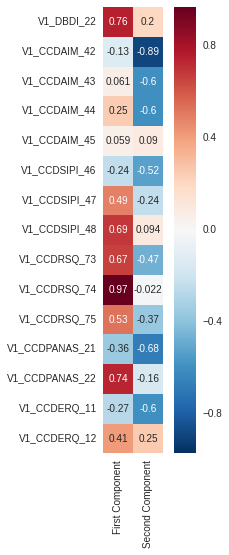

In [8]:
fig,ax=plt.subplots(figsize=(4,8))
sns.heatmap(data=true_components,annot=True, fmt='.2g',square=True,yticklabels=phenoNames,xticklabels=['First Component','Second Component'])

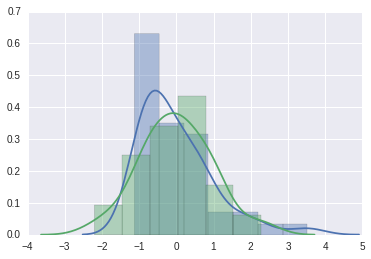

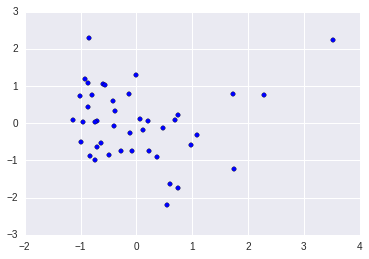

In [10]:
sns.distplot(subjectLoadings[:,0])
sns.distplot(subjectLoadings[:,1])

plt.figure()
plt.scatter(subjectLoadings[:,0],subjectLoadings[:,1])

In [9]:
df=pd.DataFrame(data=subjectLoadings,columns=['FirstComp','SecondComp'],index=goodsubj)
df.to_csv('FA_subjectloadings_new.csv')

In [11]:
df

,FirstComp,SecondComp
CCD012,0.609951,-1.623004
CCD014,0.985529,-0.580966
CCD015,-0.386983,0.325953
CCD016,1.758720,-1.226907
CCD017,-0.279444,-0.748290
CCD018,-0.004215,1.282598
CCD019,0.746426,-1.739985
CCD020,-0.496978,-0.857481
CCD021,3.518514,2.224340
CCD022,-0.703404,-0.631885


In [1]:
! pwd

/home/jmuraskin/Projects/CCD/CCD-scripts/analysis
